## IMPORT DEPENDENCIES

In [42]:
# visualization and numeric computation
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# vectorizer and cosine similarity 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# tools for web-scrapping
import requests
from bs4 import BeautifulSoup

# tools for nlp
import re
import nltk
import spacy
import gensim
import textstat
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
from nltk.tokenize import sent_tokenize, word_tokenize

lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_lg")
warnings.simplefilter("ignore")

In [24]:
#!pip install textstat

     -------------------------------------- 105.1/105.1 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 3.9 MB/s eta 0:00:00


## NEWS ARTICLE SCRAPPING

In [2]:
agent = {"User-Agent":'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) \
          Chrome/59.0.3071.115 Safari/537.36'}


"""  HINDUSTAN TIMES NEWS ARTICLE SCRAPPING  """

def collect_news_hindustan_times(topic,page_count):
    
    domain = "https://www.hindustantimes.com"
    df = pd.DataFrame(columns = ["title","text","topic"])
    
    for idx in range(1,page_count+1):
        for t in topic:
            url = f"{domain}/{t}/page-{idx}"

            r = requests.get(url,headers = agent)
            soup = BeautifulSoup(r.content,"html.parser")

            headline = soup.find_all("h3",{"class":"hdg3"})

            while headline:
                h = headline.pop(0)
                preview = h.text
                href = h.find_all("a",href=True)[0]['href']

                href_url = f"{domain}{href}"
                req = requests.get(href_url, headers = agent)
                article = BeautifulSoup(req.content, "html.parser")

                details = article.find("div",{"class":"detail"})
                if details != None:
                    article_text = details.find("p")
                    s = ""
                    for i in article_text: s += f" {i.text}"
                    df = df.append({"title":preview, "text":s, "topic":t}, ignore_index = True)

    return df

# -----------------------------------------------------------------------------------------------------------------#

"""  NDTV NEWS ARTICLE SCRAPPING  """

def collect_news_ndtv(topic,page_count):
    domain = "https://www.ndtv.com"
    df = pd.DataFrame(columns = ["title","text","topic"])
    for idx in range(1,page_count+1):
        for t in topic:
            url = f"{domain}/{t}/page-{idx}"
            r = requests.get(url)
            if r.status_code != 404:
                soup = BeautifulSoup(r.content, "html.parser")
                headline = soup.find_all("div",{"class":"news_Itm"})

                while headline:
                    h = headline.pop(0)

                    preview = h.find("h2",{"class":"newsHdng"})
                    if preview != None:
                        title = preview.text
                        article_url = preview.find("a",href=True)['href']

                        _r = requests.get(article_url)
                        _soup = BeautifulSoup(_r.content, "html.parser")
                        _text = _soup.find("div",{"itemprop":"articleBody"})
                        if _text != None: 
                            text_ = _text.find_all("p")
                            s = ""
                            for i in text_: s += f" {i.text}"
                            df = df.append({"title":title, "text":s, "topic":t},ignore_index = True)
    
    return df

In [192]:
topic = ["india-news","world-news","cricket","entertainment","lifestyle","astrology"]
hindustan_times = collect_news_hindustan_times(topic,20)

In [167]:
topics = ["india","covid","world","science","weather","people","latest"]
ndtv = collect_news_ndtv(topics,20)

In [169]:
ndtv.to_csv("ndtv.csv")

In [185]:
ndtv.sample(7)

,title,text,topic
182,Human Brain Cells Implanted In Rats To Study S...,Researchers implanted the groupings of human ...,science
32,"Who Is Sukhvinder Singh Sukhu, Himachal Prades...",He was president of the state Youth Congress ...,people
60,"""Sheezan Khan Slapped Tunisha Sharma On Set Wh...",Fellow TV actor and Tunisha Sharma's ex boyfr...,india
248,Tedros Adhanom Ghebreyesus: Child Of War To Tw...,Tedros Adhanom Ghebreyesus is the first Afric...,people
386,Eknath Shinde's No Arrest Order For Team Uddha...,Eknath Shinde assured the Legislative Council...,india
607,Actor Riya Kumari Shot Dead In Bengal During H...,A gang of three men attacked the woman's husb...,india
635,"Ahmed Patel, Congress Troubleshooter, Sonia Ga...",Ahmed Patel represented Gujarat eight times i...,people


In [194]:
hindustan_times.to_csv("hindustan_times.csv")

In [199]:
hindustan_times.sample(5)

,title,text,topic
478,ved Katrina Kaif's airport look in PJs with Vi...,Actor-couple Katrina Kaif and Vicky Kaushal ...,lifestyle
2828,anji final loss last year will inspire Mumba,"Amol Muzumdar liked to keep things simple, be...",cricket
1392,"case against Lalu, Tejashwi's swipe at CBI. B...",Bihar Deputy Chief Minister Tejashwi Yadav on...,india-news
960,"reena Kapoor, Saif Ali Khan reach Gstaad for n...",Kareena Kapoor has been visiting Gstaad in th...,entertainment
1031,"orpio Horoscope Today, December 20, 2022: Turn...","Daily Astrological Prediction says, scorpio, ...",astrology


In [195]:
combined = pd.concat([hindustan_times,ndtv],axis=0,ignore_index=True)
combined.shape

(4094, 3)

In [198]:
combined.to_csv("master_data.csv")

# NEWS ARTICLES DATASET EXPLORATION

In [3]:
news = pd.read_csv("master_data.csv")
news.drop("Unnamed: 0", axis=1, inplace=True)
news.sample(5)

,title,text,topic
1137,raddha Walker murder case forced breakup with ...,Amid the ongoing probe of Tunisha Sharma 's ...,entertainment
2666,tralekhaa: I am still trying to come to terms ...,"As 2022 comes to a close, actor Patralekhaa l...",entertainment
1988,ehnaaz Gill invites people to get clicked with...,Actor-singer Shehnaaz Gill asked people to ...,entertainment
3775,Scientists Find Fossil Of Prehistoric Bear-Dog...,Many different types of amphicyonid species e...,science
2057,roscope Today: Astrological prediction for Dec...,All zodiac signs have their own characteristi...,astrology


In [4]:
# Renaming all topic name - "india-news" to "india"

for i in range(news.shape[0]): 
    if news["topic"][i] == "india-news": news["topic"][i] = "india"

In [5]:
news.topic.unique()

array(['india', 'world-news', 'cricket', 'entertainment', 'lifestyle',
       'astrology', 'science', 'people', 'latest'], dtype=object)

In [6]:
# Adding ARTICLE_ID

l = news.shape[0]
article_id = [i for i in range(1,l+1)]
news["article_id"] = pd.Series(article_id)

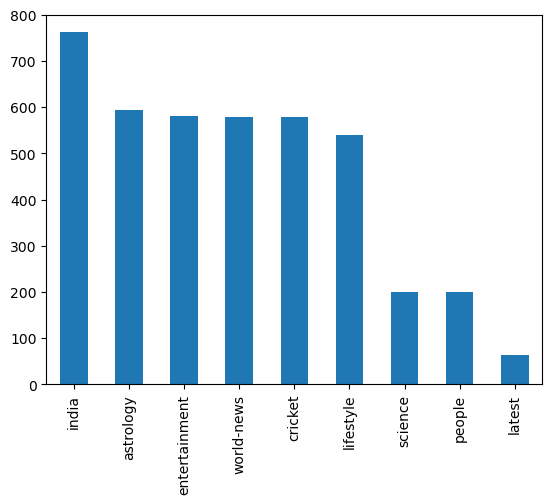

In [7]:
# Distribution of Topics

news.topic.value_counts().plot.bar()
plt.show()

In [89]:
news.sample(5)

,title,text,topic,article_id
132,India's SARAS Telescope Finds Clues To First G...,The indigenously-made telescope was deployed ...,science,4391
2092,lit man beaten up for refusing to withdraw cas...,Bhopal: A Dalit man was allegedly beaten up a...,india,2093
1778,raine to receive up to $2.65 billion in aid fr...,The Netherlands will provide Ukraine with up ...,world-news,1779
2373,ternational Tea Day: 3 immunity-boosting tea r...,International Tea Day : The special day is al...,lifestyle,2374
3346,"went in that day. Heard, 'We don't pay you to...",The drama surrounding David Warner 's decisi...,cricket,3347


### TEXT PRE-PROCESSING AND WORD EMBEDDING

In [12]:
# removal of punctuations
# removal of stopwords
# lemmatization of words
# lower case conversion

def pre_process(text):
    corpus = []
    for i in range(len(text)):
        r = re.sub("[^a-zA-Z]"," ",text[i])
        r = r.split()
        r = [word for word in r if word not in stopwords.words("english")]
        r = [lemmatizer.lemmatize(word) for word in r]
        r = " ".join(r)
        corpus.append(r.lower())
    return corpus

In [123]:
titles = pre_process(list(news.title))

In [124]:
nlps = [nlp(i) for i in titles]

In [15]:
type(nlps[1])

spacy.tokens.doc.Doc

### GROUP SIMILAR ARTICLES BASED ON COSINE SIMILARITY METRIC

#### 1. TF-IDF Vectorization 

In [92]:
def most_similar_article_tfidf(id_,news):
    """
    Arguments: 
        id_: article ID
        news: the news dataset
    Returns:
        most similar articles based on cosine similarity of tf-idf vectors of news titles
    """
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(news.title)
    A = X[id_]

    ans = cosine_similarity(A,X)
    df = pd.DataFrame({'sim' : ans[0]})    
    return df.sort_values(by='sim', ascending=False).iloc[1:11]

id_ = 21
df_tfidf = most_similar_article_tfidf(id_, news)
df_tfidf

,sim
22,0.319520
3551,0.307967
369,0.286178
883,0.255819
368,0.246428
703,0.225200
2757,0.210583
4607,0.203123
4442,0.203123
4113,0.203123


In [99]:
print(f"Title of previously read article : '{news.iloc[id_].title}'\nSimilar articles:\n")
news[news.article_id.isin(df_tfidf.index + 1)]

Title of previously read article : ' Modi arrives in Ahmedabad as mother passes away, no programmes cancell'
Similar articles:



,title,text,topic,article_id
22,Modi's mother Heeraben passes away: ‘Glorious...,Prime Minister Narendra Modi's mother Heerabe...,india,23
368,ening brief: PM Modi's mother Heeraben is reco...,"Here are today’s top news, analysis, and opin...",india,369
369,"Modi's mother Heeraben is recovering, says Ah...",Prime Minister Narendra Modi's mother Heerabe...,india,370
703,di rushes to Ahmedabad as ailing mother taken ...,Prime Minister Narendra Modi on Wednesday vis...,india,704
883,"Modi visited mother Heeraben, who is admitted...","Heeraben Modi, prime minister Narendra Modi ...",india,884
2757,teran Tollywood actor and ex-MP Kaikala Satyan...,Veteran Tollywood actor and former parliament...,india,2758
3551,PM Modi's Mother Heeraben Dies At 99 In Ahmedabad,"Prime Minister Narendra Modi's mother, Heerab...",india,3552
19,PM Modi Arrives At Massive Kolkata Rally As Mi...,West Bengal Assembly Election: PM Modi will a...,entertainment,4114
19,PM Modi Arrives At Massive Kolkata Rally As Mi...,West Bengal Assembly Election: PM Modi will a...,entertainment,4443
19,PM Modi Arrives At Massive Kolkata Rally As Mi...,West Bengal Assembly Election: PM Modi will a...,entertainment,4608


#### 2. Doc2Vec Vectorization

In [111]:
def most_similar_article_doc2vec(id_,news):
    """
    Arguments: 
        id_: article ID
        news: the news dataset
    Returns:
        most similar articles based on cosine similarity of doc2vec embeded vectors of news titles
    """
    
    def tagged_document(list_of_list_of_words):
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

    data = ""
    for title in news.title:
        data += title + " "  

    data_ = []
    for i in sent_tokenize(data):
        temp = []
        for j in word_tokenize(i): temp.append(j.lower())
        data_.append(temp)

    data_for_training = list(tagged_document(data_))

    model = gensim.models.Doc2Vec(data_for_training)
    model.build_vocab(data_for_training)
    model.train(data_for_training, total_examples=model.corpus_count, epochs = model.epochs)

    a = news.iloc[id_].title
    vec_a = model.infer_vector(a.split())

    ids,sim = [],[]
    for idx,item in enumerate(news.title):
        ids.append(idx)
        vec2 = model.infer_vector(item.split())
        sim.append(cosine(vec1,vec2))
    
    df_ = pd.DataFrame({"article_id":ids, "similarity":sim})
    
    return df_.sort_values(by="similarity")[1:11]

id_ = 21
df_doc2vec = most_similar_article_doc2vec(id_,news)
df_doc2vec

,article_id,similarity
3182,3182,0.626029
566,566,0.633514
2320,2320,0.638634
2832,2832,0.640039
2507,2507,0.650870
1956,1956,0.651427
1667,1667,0.654763
1129,1129,0.655400
2669,2669,0.658413
1235,1235,0.663646


In [112]:
print(f"Title of previously read article : '{news.iloc[id_].title}'\nSimilar articles:\n")
news[news.article_id.isin(df_doc2vec.article_id)]

Title of previously read article : ' Modi arrives in Ahmedabad as mother passes away, no programmes cancell'
Similar articles:



,title,text,topic,article_id
565,house panel to release Donald Trump’s tax ret...,Years of former President Donald Trump’s tax ...,world-news,566
1128,pul Shah on The Kerala Story criticism: 'Nothi...,"Vipul Amrutlal Shah 's next as producer, The ...",entertainment,1129
1234,-year-old girl attacked with battery acid in A...,A 17-year-old girl was attacked with battery ...,india,1235
1666,ah Rukh Khan's Baadshah song syncs perfectly w...,The second song from Shah Rukh Khan and Dee...,entertainment,1667
1955,tch - 'Dhoni bhai ka signature hai': Ishan Kis...,"As stars, Indian cricketers come across count...",cricket,1956
2319,tch: Kohli's reaction wins hearts as Pujara sm...,Team India's star batter Cheteshwar Pujara ...,cricket,2320
2506,reena Kapoor shares Taimur Ali Khan's pics pre...,Actor Kareena Kapoor wished her elder son T...,entertainment,2507
2668,"ttey trailer: Arjun Kapoor, Tabu are out to cr...",The trailer of the upcoming film Kuttey shows...,entertainment,2669
2831,Rahul gives crucial update on Rohit Sharma ah...,Indian vice-captain KL Rahul is all set to ...,cricket,2832
3181,"rdo, False Chronicle of a Handful of Truths re...",What is an Alejandro G. Iñárritu film if it n...,entertainment,3182


#### 3. Using Spacy along with pretrained pipeline "en_core_web_lg"

In [125]:
def most_similar_article( id_, master_data = nlps, new_data = None):
    """
    arguments:
        nlps: spacy token obejcts
        id_ : article ID (of target article)
    
    returns:
        articles which are similar to the target article
        here, measure of similarity is -
              Cosine Similarity between article titles and target 
             [The closer the cosine value of the angle between two 
              embedded vectors is to 1, the more semantically similar
              the two sentences are.]
    """
    
    if new_data == None: new_data = master_data
    else: master_data.extend(new_data)
        
    similars = []
    target = master_data[id_-1]
    
    df = pd.DataFrame(columns = ["article_id","similarity"])
    
    for i in range(len(new_data)):
        s = target.similarity(new_data[i])
        df = df.append({"article_id":i+1, "similarity":s},ignore_index=True)
    
    df = df.sort_values(by="similarity",ascending = False)[1:11]
    df["article_id"] = df["article_id"].apply(lambda x: int(x))
    
    return df.reset_index().drop("index",axis=1)

In [126]:
df_sim = most_similar_article(id_ = 21)
df_sim

,article_id,similarity
0,2,0.756499
1,1753,0.753560
2,2944,0.749369
3,2511,0.736782
4,534,0.731624
5,1781,0.700877
6,1581,0.696667
7,3450,0.694646
8,2078,0.692410
9,4041,0.685789


In [127]:
news

,title,text,topic,article_id
0,Khurshid’s comment proves Kharge is remote-con...,Assam chief minister Himanta Biswa Sarma on T...,india,1
1,aders extend condolences to PM Modi on his mot...,Political leaders of various parties and chie...,india,2
2,wrah-New Jalpaiguri Vande Bharat Express: Spee...,Prime Minister Narendra Modi on Friday flagge...,india,3
3,ternoon brief: Tourists in over 400 vehicles r...,"Here are today’s top news, analysis, and opin...",india,4
4,di virtually flags off Vande Bharat Express in...,Prime Minister Narendra Modi virtually flagge...,india,5
...,...,...,...,...
160,IIFA 2023: Awards To Be Held In May. Details Here,IIFA Awards will take place in Yas Island. (c...,latest,4749
161,Jack Ma To Give Up Control Of Ant Group After ...,Ant Group's founder Jack Ma will no longer co...,latest,4750
162,"To Bipasha Basu On Her Birthday, With Love Fro...",Bipasha with Karan. (courtesy: iamksg) It is ...,latest,4751
163,Mumbai Man Who Peed On Woman On Air India Flig...,"He was on the run, and a lookout notice or ai...",latest,4752


In [128]:
print(f"Title of previously read article : '{news.iloc[id_].title}'\nSimilar articles:\n")
news[news.article_id.isin(df_sim.article_id)]

Title of previously read article : ' Modi arrives in Ahmedabad as mother passes away, no programmes cancell'
Similar articles:



,title,text,topic,article_id
1,aders extend condolences to PM Modi on his mot...,Political leaders of various parties and chie...,india,2
533,"rning brief: Tejashwi, not Nitish, to take par...","Here are today’s top news, analysis, and opin...",india,534
1580,eak free from narrow views of past: PM Modi at...,Prime Minister Narendra Modi hailed the Sikh ...,india,1581
1752,"ghlights: PM Modi, Ukraine President Zelensky ...",Welcome to hindustantimes.com updates platfor...,india,1753
1780,PM Rishi Sunak 'disappointed' by disruption c...,British Prime Minister Rishi Sunak said on Fr...,world-news,1781
2077,"vid precaution, India 2022 milestones in PM's ...",Prime Minister Narendra Modi addressed his mo...,india,2078
2510,dharth Malhotra greets PM Narendra Modi with f...,Actor Sidharth Malhotra was invited at the ...,entertainment,2511
2943,ovid isn’t over': PM Modi calls for ramped up ...,Prime Minister Narendra Modi on Thursday caut...,india,2944
3449,PM Modi Virtually Flags Off Bengal's 1st Vande...,PM Modi virtually flagged off the Vande Bhara...,india,3450
4040,"""Nothing Unusual"": Nitish Kumar On Skipping Me...",Nitish Kumar sought to downplay his frequent ...,india,4041


## USER DATA GENERATION

In [82]:
available_topics = ['india-news', 'world-news', 'cricket', 'entertainment','lifestyle', 
                    'astrology', 'india', 'science', 'people', 'latest']

class User():
    """
    This class is to create artificial user bot who would interact with recommended articles.
    The bot chooses some articles to read and leaves behind a clickstream history. 
    """
    
    def __init__(self):
        
        self.id = len(all_users) + 1
        self.p = random.uniform(0.2,0.5)
        self.clickrate = []
        self.history = pd.DataFrame(columns=["article_id","click","time_spent(sec)"])

    def choice_maker(self,n_):
        
        while True:
            choice = np.random.binomial(n=1,p=self.p,size=n_)
            if 1 in choice: break
        choice = np.where(choice == 1, True, False)
        
        return choice
    
    def read_article(self,articles):
        
        n, _article_id, _read = articles.shape[0], list(articles.article_id), []
        _choice = self.choice_maker(n)
        session_id = len(self.history) // n + 1

        for i in range(n):
            
            self.history = self.history.append({
                                 "user_id": self.id,
                                 "session_id": session_id,
                                 "article_id":_article_id[i],
                                 "click": True if _choice[i] else False,
                                 "time_spent(sec)":np.random.randint(1,120) if _choice[i] else 0},
                                              ignore_index = True)
            
        self.history["session_id"] = self.history["session_id"].apply(lambda x: int(x))
        self.history["user_id"] = self.history["user_id"].apply(lambda x: int(x))
        self.clickrate.append(sum(_choice))
        return


def create_user_bot():
    '''
    Creates a user object and adds it to a universal register of all users.
    '''
    u = User()
    all_users[u.id] = u
    return u            

# ------------------------------------------------------------------------------------------------------------------------#
# ------------------------------------------------------------------------------------------------------------------------#
# ------------------------------------------------------------------------------------------------------------------------#


class Recommender():
    """
    This class is for generating recommendations based on user interaction history.
    It 
        - takes in the user_id
        - retrieves previous history of user
        - computes similarity index of the article titles the 
          user have read with those the user haven't seen yet
        - sorts the articles in decreasing order of similarity index
        - returns top 10 results for recommending to the user
    
    Everytime a user starts a session, fresh news is scrapped from the internet 
    and among those the most similar 10 articles are served.
    """
    
    def __init__(self,user_id = None):
        self.id = user_id
        
    
    def scrap_articles(self,news):
        
        print("Status: Gathering latest articles for you...")
        scrap_new = collect_news_ndtv(available_topics,2)
        
        ids = [news.shape[0]+i for i in range(1,scrap_new.shape[0]+1)]
        scrap_new["article_id"] = pd.Series(ids)
        
        # update dataset
        news = pd.concat([news,scrap_new],axis=0)
        news.reset_index()
        
        # embedding of the titles
        titles_ = pre_process(list(scrap_new.title))
        titles_ = [nlp(i) for i in titles]
        
        return news, scrap_new, titles_
    
    
    def generate_history(self):
        
        print("Status: History Generation in progress...")
        h = all_users[self.id].history
        
        return h[h.click == True]
    
    
    def content_based_similar(self,new_data,read):
        
        print("Status: Looking for articles you might like...")
        
        # look for similar articles 
        for i in range(read.shape[0]):
            if i == 0: recommended = most_similar_article(new_data = new_data, id_ = read[i])
            
            # assemble all similar articles in one dataframe
            else: recommended = pd.concat([recommended,most_similar_article(new_data = new_data, id_ = read[i])],axis=0)

        # sort articles based on similarity
        return_ = recommended.sort_values(by="similarity",ascending=False)
        
        # remove duplicates and previously read articles
        return_ = return_[~return_["article_id"].isin(read)]
        return_.drop_duplicates(subset="article_id",inplace=True)
        return_.reset_index()
        #return_.drop("index",axis=1,inplace=True)
        
        print("Status: Successfully found some articles for you...")
        return return_
    
    
    def generate_recommendations(self,news_):
        
        
        news_, sc, t = self.scrap_articles(news_)
        
        history = self.generate_history()
        if history.shape[0] == 0: return news_,sc.sample(10)
        
        # ids of previously read articles
        read_id = history.article_id.values
        
        similar = self.content_based_similar(new_data = t, read = read_id)[:5]
        #print("similsr\n",similar)
        dissimilar = sc[~sc["article_id"].isin(similar.article_id)].sample(5)
        #print("dissimilsr\n",dissimilar)
        recommend = pd.concat([similar,dissimilar],axis=0)
        #print("Prepare your eyes.")
        
        return news_,recommend

In [83]:
all_users = {}

# creating a new user bot
new_user = create_user_bot()

# bilding a recommender bot for the user
rec = Recommender(user_id = new_user.id)

# updates the news dataset with new articles
news,r = rec.generate_recommendations(news)

# recommended articles are served to the user
new_user.read_article(r)

# collecting the user's interaction
h = new_user.history
h

Status: Gathering latest articles for you...
Status: History Generation in progress...


,article_id,click,time_spent(sec),session_id,user_id
0,4535,True,25,1,1
1,4520,False,0,1,1
2,4467,False,0,1,1
3,4469,True,51,1,1
4,4438,True,110,1,1
5,4447,False,0,1,1
6,4470,False,0,1,1
7,4449,False,0,1,1
8,4426,False,0,1,1
9,4454,False,0,1,1


In [84]:
news[news.article_id.isin(h.article_id)]

,title,text,topic,article_id
2,"Russia Continues To Shell Ukraine, Troops Ask ...",Ukraine has said it has no intention to stop ...,world-news,4426
14,"World Food Prices Hit Record High In 2022, Say...",World food prices eased in December marking t...,world-news,4438
23,Indians Are 'Boycotting' Spiderman Star For PM...,"Sardar Patel Stadium, Motera, was on Wednesda...",entertainment,4447
25,RRR: Ram Charan And Jr NTR's Film To Release O...,The makers of RRR shared a new poster. (court...,entertainment,4449
30,"Kerala Woman Orders Biryani Online, Dies After...",A woman in Kasaragod died after eating 'Kuzhi...,india,4454
43,"On Assam-Meghalaya Border Pact, Supreme Court ...",Chief Ministers of Assam and Meghalaya with H...,india,4467
45,Autopsies Show Covid Virus Lingers In Brain Fo...,"The SARS-CoV-2 virus spreads to the brain, an...",science,4469
46,Your Blood Type May Predict Your Risk Of Havin...,The ages of all participants ranged from 18 t...,science,4470
96,"US Man Kills Family Of 7, Including 5 Children...",Man kills family: The suspect reportedly took...,world-news,4520
111,Malaika Arora Shared This Bernie Sanders Meme ...,Malaika Arora shared this image. (courtesy ma...,entertainment,4535


In [85]:
news,r = rec.generate_recommendations(news)
new_user.read_article(r)
h2 = new_user.history
h2

Status: Gathering latest articles for you...
Status: History Generation in progress...
Status: Looking for articles you might like...
Status: Successfully found some articles for you...


,article_id,click,time_spent(sec),session_id,user_id
0,4535,True,25,1,1
1,4520,False,0,1,1
2,4467,False,0,1,1
3,4469,True,51,1,1
4,4438,True,110,1,1
5,4447,False,0,1,1
6,4470,False,0,1,1
7,4449,False,0,1,1
8,4426,False,0,1,1
9,4454,False,0,1,1


In [135]:
pd.merge(news[news.article_id.isin(h2.article_id)],h2,on = "article_id").sort_values(by=["session_id"])

,title,text,topic,article_id,click,time_spent(sec),session_id,user_id
9,"Kerala Woman Orders Biryani Online, Dies After...",A woman in Kasaragod died after eating 'Kuzhi...,india,4454,False,0,1,1
14,Malaika Arora Shared This Bernie Sanders Meme ...,Malaika Arora shared this image. (courtesy ma...,entertainment,4535,True,25,1,1
5,"Russia Continues To Shell Ukraine, Troops Ask ...",Ukraine has said it has no intention to stop ...,world-news,4426,False,0,1,1
6,"World Food Prices Hit Record High In 2022, Say...",World food prices eased in December marking t...,world-news,4438,True,110,1,1
7,Indians Are 'Boycotting' Spiderman Star For PM...,"Sardar Patel Stadium, Motera, was on Wednesda...",entertainment,4447,False,0,1,1
8,RRR: Ram Charan And Jr NTR's Film To Release O...,The makers of RRR shared a new poster. (court...,entertainment,4449,False,0,1,1
13,"US Man Kills Family Of 7, Including 5 Children...",Man kills family: The suspect reportedly took...,world-news,4520,False,0,1,1
10,"On Assam-Meghalaya Border Pact, Supreme Court ...",Chief Ministers of Assam and Meghalaya with H...,india,4467,False,0,1,1
11,Autopsies Show Covid Virus Lingers In Brain Fo...,"The SARS-CoV-2 virus spreads to the brain, an...",science,4469,True,51,1,1
12,Your Blood Type May Predict Your Risk Of Havin...,The ages of all participants ranged from 18 t...,science,4470,False,0,1,1
